# Wigner's friend of a friend of a friend paradox: can quantum mechanics describe users of quantum mechanics?

What if quantum theory is not just weird and counterintuitive, but genuinely contains contradictions? Today's paradox claims to show an internal contradiction in quantum theory. If this is true, it's a really big deal. It would mean that quantum theory as we know it, cannot fully describe the world around us. 

Welcome back to the quantum paradoxes video series! In each episode, I explain a quantum thought experiment and how to understand it better using quantum computing. 

In my previous paradox videos, I've discussed some of the strange consequences of treating observers as quantum systems - for example, an observer could be in a superposition of seeing Schrodinger's cat being dead and seeing it alive. But while that may sound absurd, it is fully self-consistent with the laws of quantum mechanics. 

Today's thought experiment claims to show that quantum theory cannot be consistently applied to observers that themselves use quantum theory. 

I will show you how we can simplify this thought experiment into a quantum circuit, and resolve the apparent paradox. 

### Context of the paradox 

The thought experiment was proposed by Daniela Frauchiger and Renatto Renner in 2016. It involves four observers who use quantum mechanics to reason about the outcomes of each others' measurements, and then find their conclusion to be in contradiction with quantum mechanics. 

It is an extension of the Wigner's friend paradox, so I've called it "Wigner's friend of a friend of a friend". In the quantum community it's often referred to as the Frauchiger-Renner paradox or as an extended Wigner's friend thought experiment. If you haven't seen my previous video on Wigner's friend, I recommend watching that before watching this one. 

If you're not familiar with bra-ket notation and quantum gates like Hadamard and CNOT, then I recommend taking a look at the introduction to quantum computing on the IBM Quantum Learning Platform before continuing with this video. 

Here's a quick reminder of the circuit I used to represent the Wigner's friend thought experiment: 

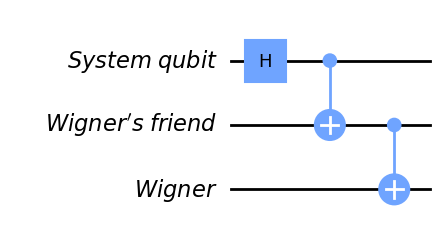

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr1 = QuantumRegister(1, name="System qubit")
qr2 = QuantumRegister(1, name="Wigner's friend")
qr3 = QuantumRegister(1, name="Wigner")

qc= QuantumCircuit(qr1, qr2, qr3)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)

qc.draw("mpl")

Wigner's friend measures a qubit in superposition, and then Wigner asks his friend what result they got. If observation causes irreversible collapse, Wigner and his friend disagree on when the irreversible collapse happened, each believing their observation caused the collapse. However, if we treat both Wigner and his friend as quantum systems, there is no contradiction: their measurements both involved them becoming entangled with the measured system, modelled by CNOT gates in the circuit. 

Things get more complicated if Wigner makes a couple more friends. 

### Extending Wigner's friend 

Let's introduce a new set of four observers: Alice, Bob, Charlotte and Danny, because Wigner's friend, Wigner's friend of a friend, and Wigner's friend of a friend of a friend might get confusing. 

We're going to start with Alice and Bob, who will each measure a qubit. Like Wigner and his friend in our previous circuit, we'll represent Alice and Bob's memories as qubits, that will store each of their measurement outcomes. 

I'll show you the first part of today's quantum circuit, and then go through each gate step by step to explain its role in the thought experiment: 

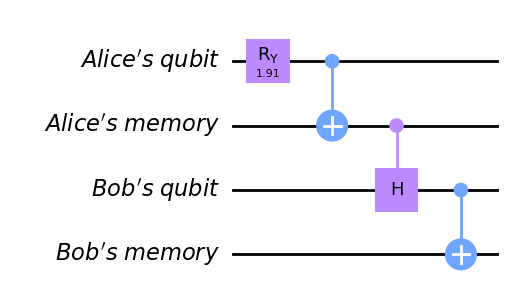

In [2]:
import numpy as np
from qiskit.circuit.library import CHGate

qr1 = QuantumRegister(1, name="Alice's qubit")
qr2 = QuantumRegister(1, name="Alice's memory")
qr3 = QuantumRegister(1, name="Bob's qubit")
qr4 = QuantumRegister(1, name="Bob's memory")

qc = QuantumCircuit(qr1, qr2, qr3, qr4)

# Prepare Alice's qubit
theta = 2 * np.arcsin(np.sqrt(2/3))
qc.ry(theta, 0)

# Alice's measurement
qc.cx(0, 1)

# Prepare Bob's qubit
qc.ch(1, 2)

# Bob's measurement
qc.cx(2, 3)

qc.draw("mpl")

The first gate is a Y-rotation gate that prepares Alice's qubit in a superposition state, which has 1/3 probability of measuring 0 and 2/3 probability of measuring 1:

$$\sqrt{\frac{1}{3}}|0\rangle + \sqrt{\frac{2}{3}}|1\rangle$$

Next, the CNOT gate represents Alice's measurement of her qubit, where she either sees the outcome 0 or 1:

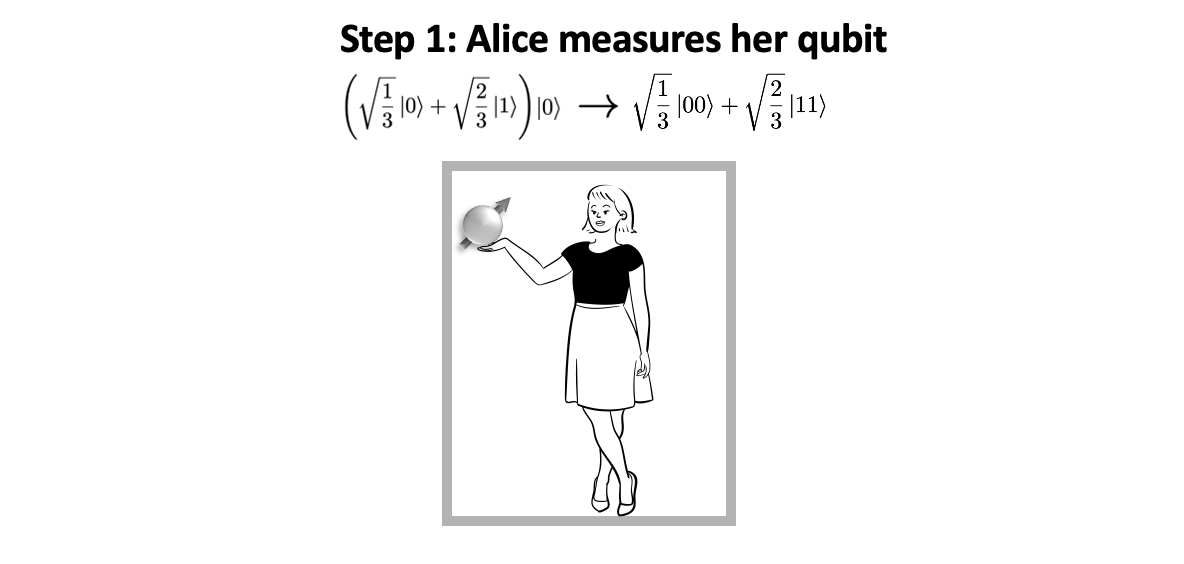

Alice then prepares Bob's qubit depending on her measurement outcome. If she measures a 0, she will prepare Bob's qubit in the 0 state. If she measures a 1, she will prepare Bob's qubit in the + state, an equal superposition of 0 and 1: 

$$H|0\rangle = \frac{1}{2}(|0\rangle + |1\rangle)$$

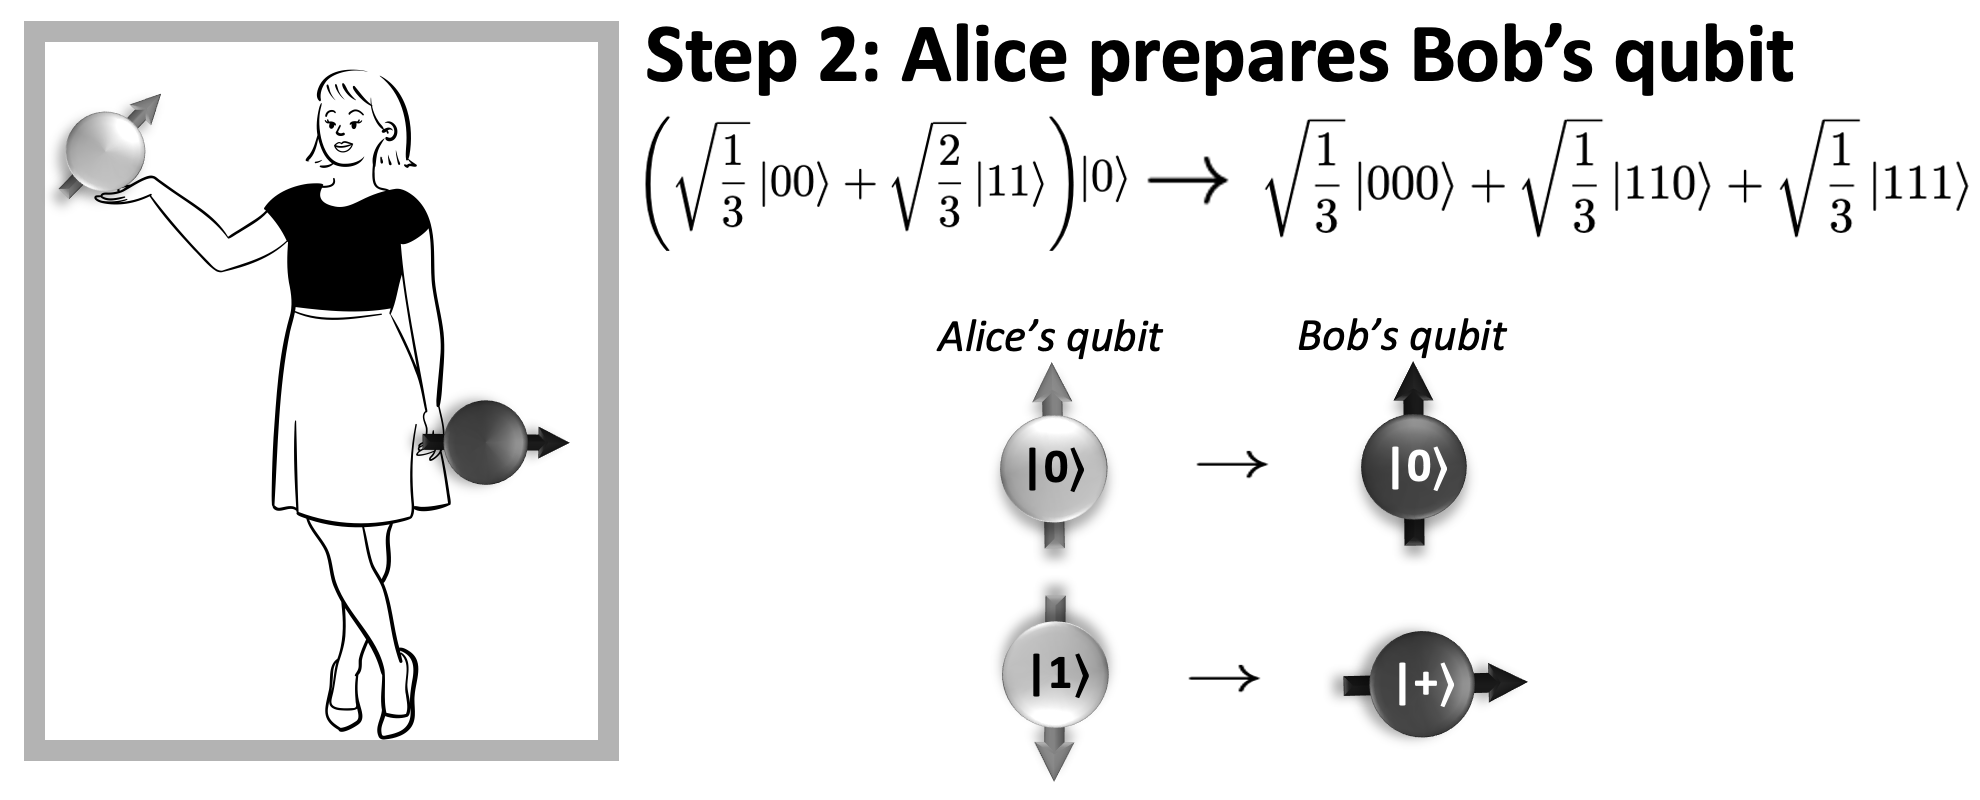

The Control-Hadamard gate implements this preparation step, because if Alice's memory qubit is 0, then Bob's qubit stays in its initialized 0 state. If Alie's memory is 1, then a Hadamard is applied to Bob's qubit to prepare it in the + state. 

Alice then gives Bob this qubit and he measures it, which is represented by another CNOT gate in our quantum circuit. 

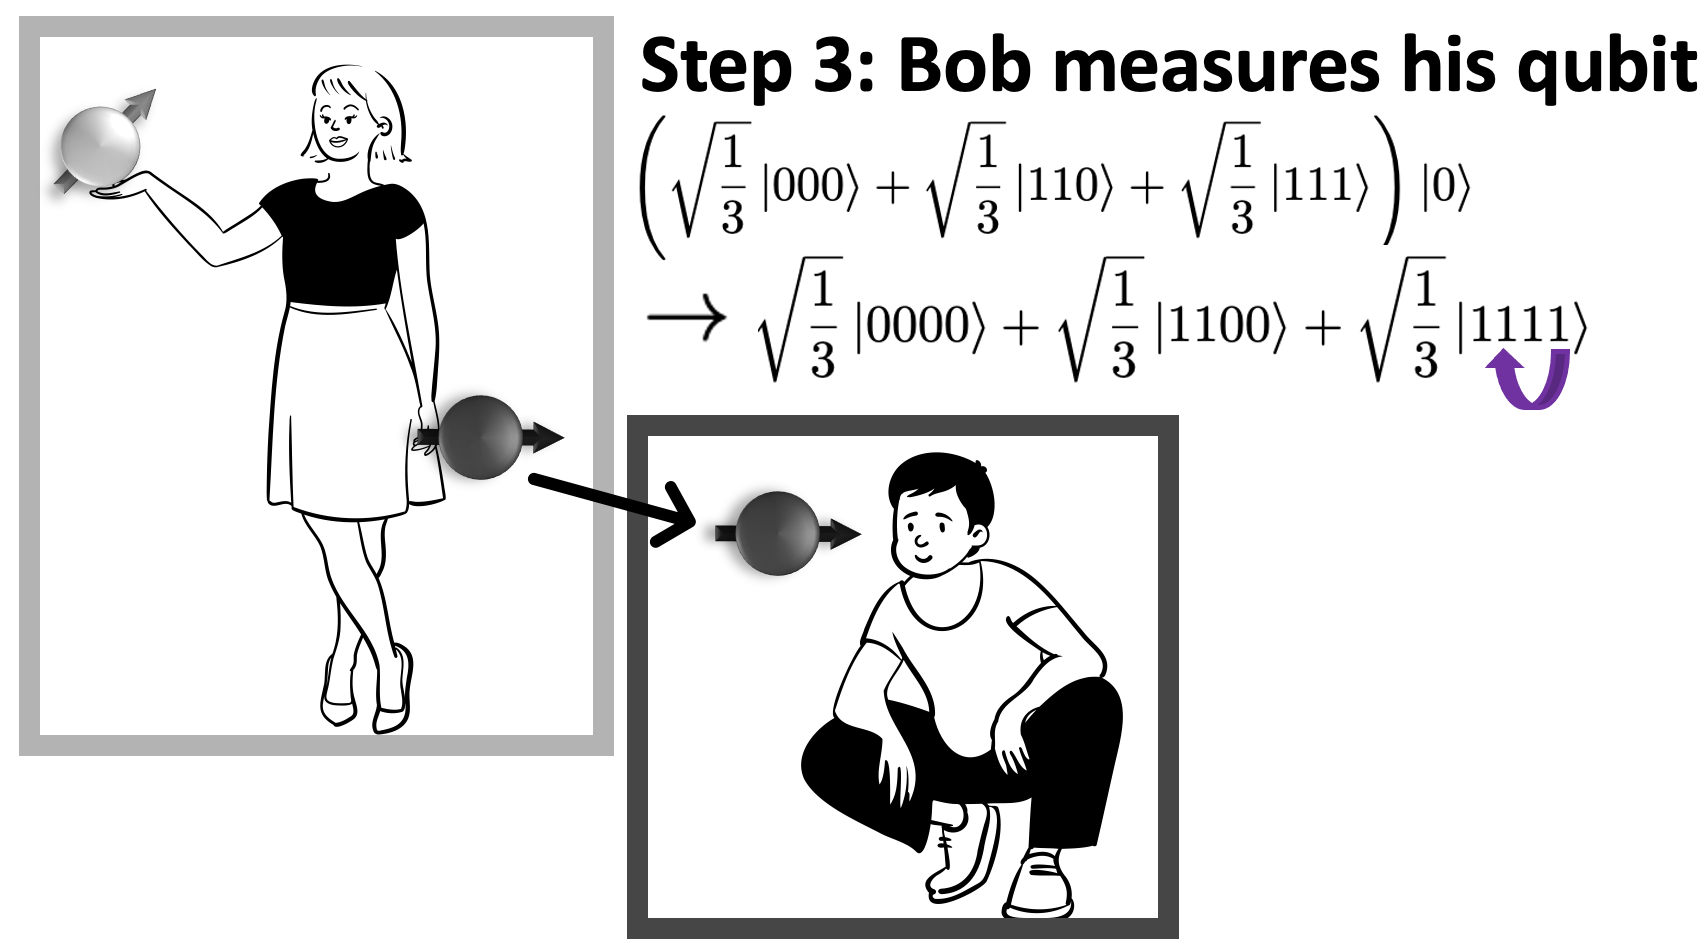

Now if Bob's measures his qubit to be in the 1 state, then he knows for sure that Alice must have prepared his qubit in the + state, not the 0 state. So if Bob measures 1, he knows that Alice must have measured 1 on her qubit. You can see this in the state vector. 

Let's check this using our quantum circuit by adding a measurement on Alice's memory qubit, after the CNOT gate, to tell us what she measured, and a measurement on Bob's memory qubit to see what he measured:  

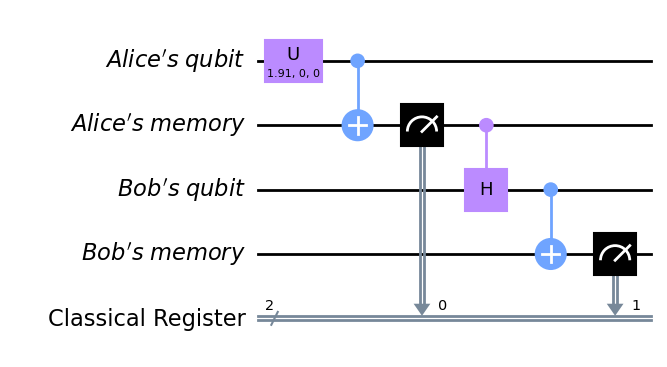

In [3]:
# Add a classical register with 2 bits
cr = ClassicalRegister(2, name="Classical Register")

# Add all the quantum and classical registers to the circuit
qc_ab = QuantumCircuit(qr1, qr2, qr3, qr4, cr)

# Prepare Alice's qubit
qc_ab.u(theta, 0, 0, 0)

# Alice's measurement
qc_ab.cx(0, 1)

# Measure the second qubit onto the first classical bit before the CH gate
qc_ab.measure(1, 0)

# Prepare Bob's qubit: controlled-Hadamard gate
qc_ab.ch(1, 2)

# Bob's measurement
qc_ab.cx(2, 3)

# Measure the fourth qubit onto the second classical bit at the end
qc_ab.measure(3, 1)

qc_ab.draw("mpl")

Let's look at the outcomes if we measure all the qubits at this stage: 

In [4]:
from qiskit_aer import AerSimulator 
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Transpile the circuit to use supported gates
backend = AerSimulator()
transpiled_circuit = transpile(qc_ab, backend)

# Execute the transpiled circuit on the Aer simulator
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(transpiled_circuit)

# Print the counts
print("Counts: ", counts)

Counts:  {'00': 316, '11': 338, '01': 370}


We see that Bob measuring a 1 on his qubit is always correlated with Alice measuring a 1 on her qubit, meaning she prepared Bob's qubit in the + state. 

### Adding friends of friends 

Now it gets weird when Charlotte and Danny enter the picture. Alice and her qubit are isolated in Alice's lab, and Bob and his qubit are isolated in Bob's lab. Charlotte and Danny are both outside these labs. We are going to assume that Charlotte and Danny have full quantum control over Alice and Bob's labs, so they can measure Alice and Bob in whatever bases they want. 

Charlotte then measures the joint system of Alice and her qubit in the Bell basis:

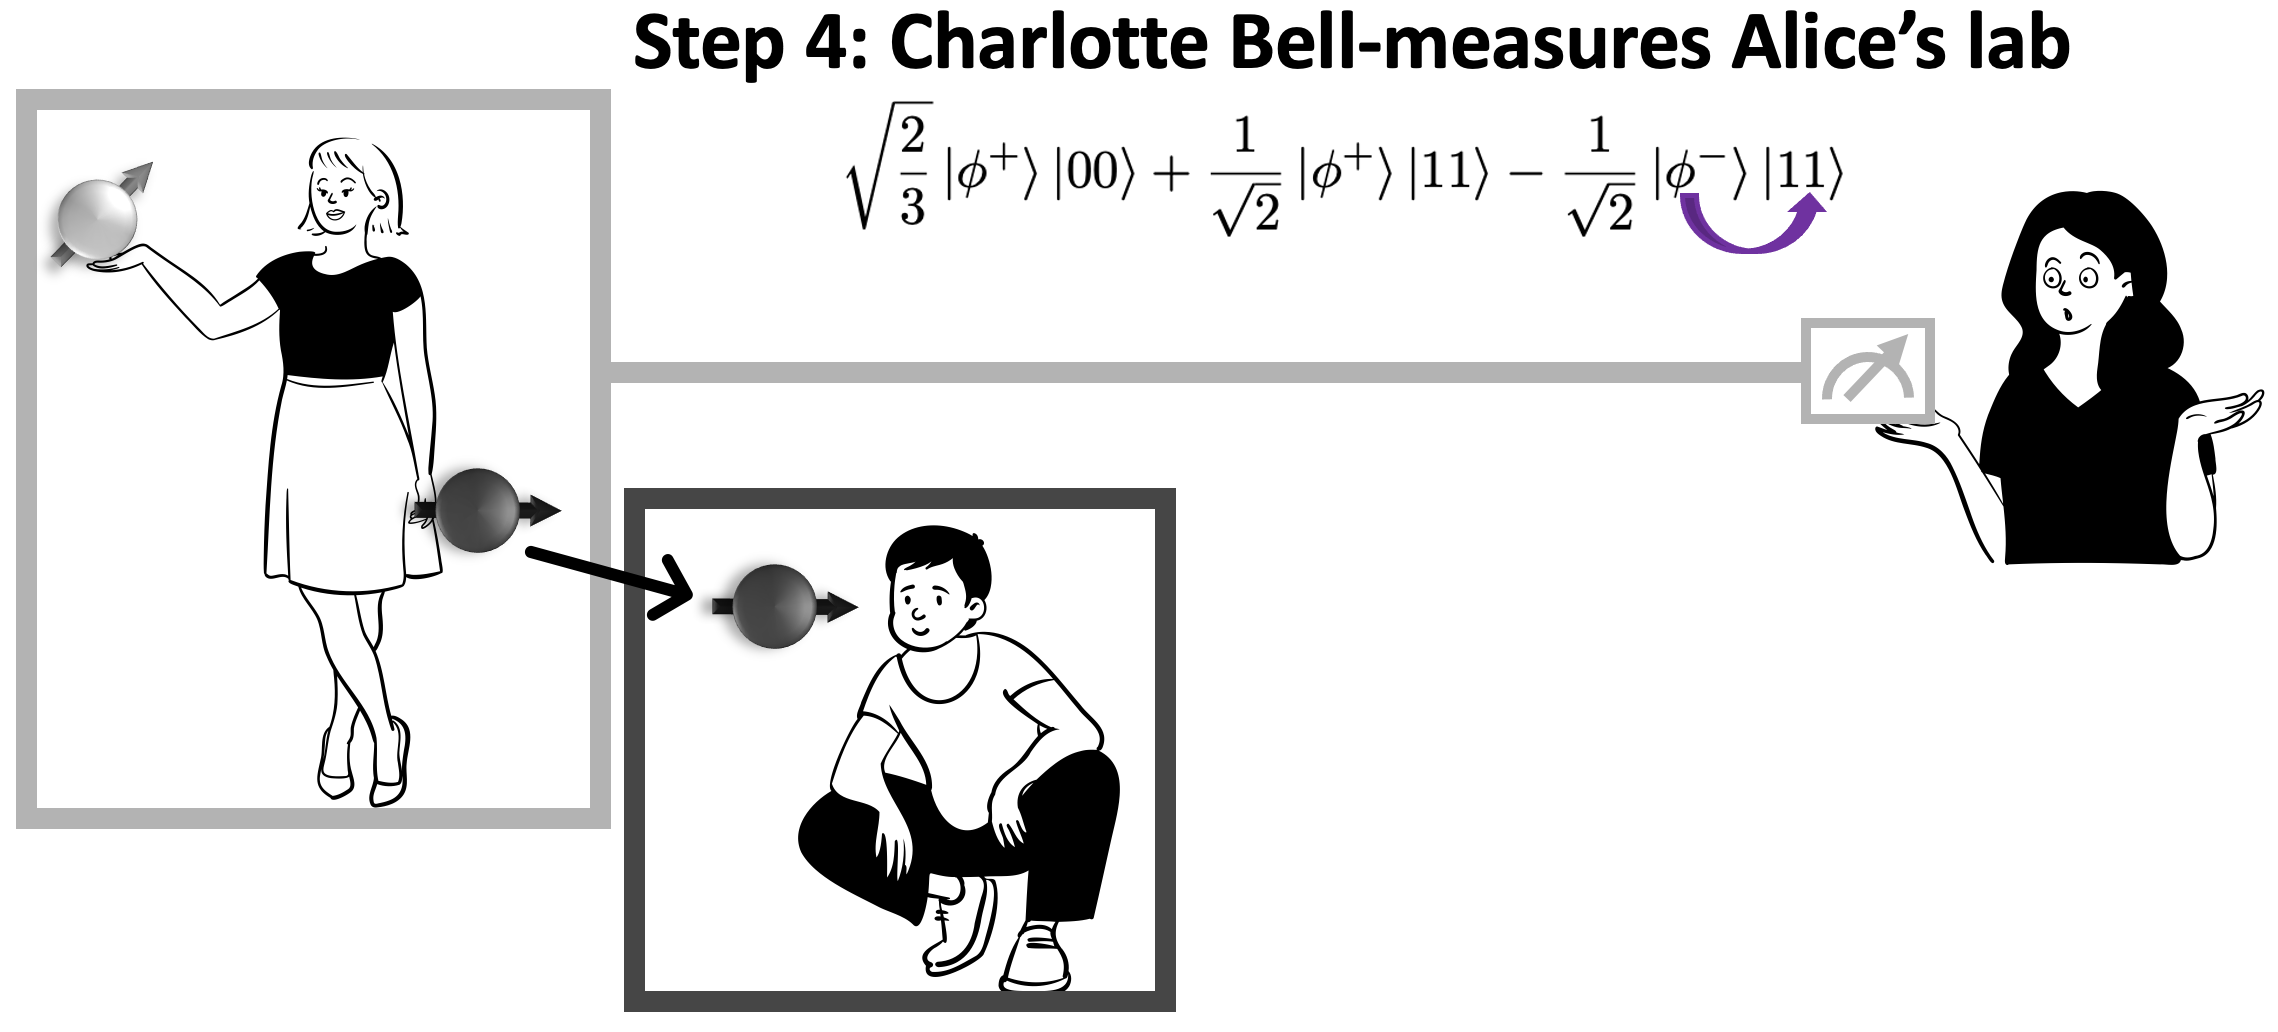

Normally we measure two qubits in the Z-basis, projecting them into the states 00, 01, 10 or 11. 

$$
|00\rangle, |01\rangle, |10\rangle , |11\rangle.
$$

By contrast a Bell basis measurement projects two qubits into one of the four maximally entangled Bell states: 00 + 11, 00 - 11, 01 + 10, and 01 - 10.

$$
|\Phi^{+}\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right), \\
|\Phi^{-}\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle - |11\rangle\right), \\
|\Psi^{+}\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle + |10\rangle\right), \\
|\Psi^{-}\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - |10\rangle\right).
$$

We can implement a Bell basis measurement by adding a CNOT then a Hadamard before doing two Z-measurements. This is similar to how we can implement an X-basis measurement by applying a Hadamard gate and then a Z-measurement. 

Let's add Charlotte's bell measurement to our quantum circuit:

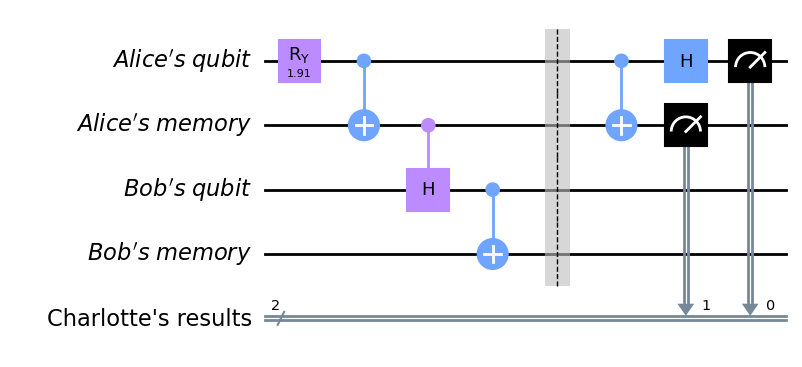

In [5]:
cr1 = ClassicalRegister(2, name="Charlotte's results")

qc.add_register(cr1)

qc.barrier()

# Bell measurement on the first pair of qubits
qc.cx(0, 1)
qc.h(0)
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw("mpl")

If Charlotte measures her qubits and gets an outcome of 10, that indicates that she measured Alice and her qubit to be in the Bell state |00> - |11>. Looking at the global statevector before Charlotte's measurement, we see that if Alice and her qubit are in that Bell state, then Bob has to have measured a 1 on his qubit. So when Charlotte gets her measurement outcome, she concludes that Bob must have measured a 1 on his qubit, with certainty. Let's check this with our circuit: 

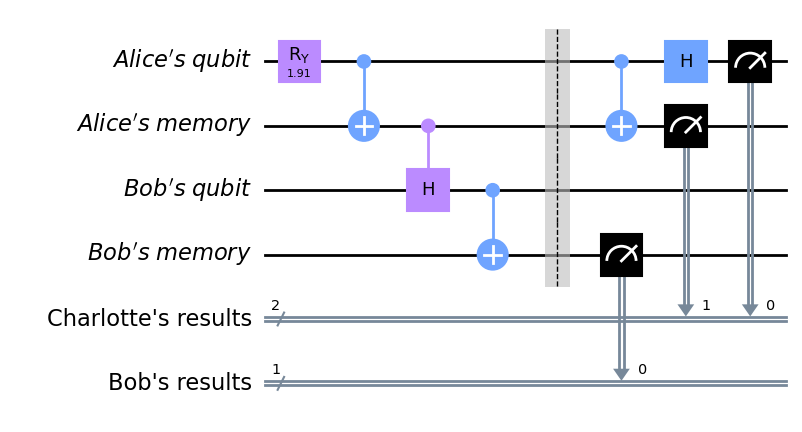

In [6]:
cr3 = ClassicalRegister(1, name="Bob's results")

qc_bc = qc.copy()
qc_bc.add_register(cr3)
qc_bc.measure(3,2)
qc_bc.draw("mpl")

In [7]:
transpiled_circuit2 = transpile(qc_bc, backend)

# Execute the transpiled circuit on the Aer simulator
result = backend.run(transpiled_circuit2).result()

counts = result.get_counts(transpiled_circuit2)

# Print the counts
print("Counts: ", counts)

Counts:  {'1 00': 161, '1 01': 171, '0 00': 692}


We see that indeed, when Charlotte measures 1 0, Bob always measures 1. 

Now we reasoned earlier that if Bob measures a 1 on his qubit, he knows for certain that Alice measured a 1 on her qubit. So now, when Charlotte gets her outcome of 1 0, she can conclude that Bob measured a 1, hence by extension Alice measured a 1. 

Next, like Charlotte did with Alice, Danny measures the joint system of Bob and his qubit in the Bell basis:

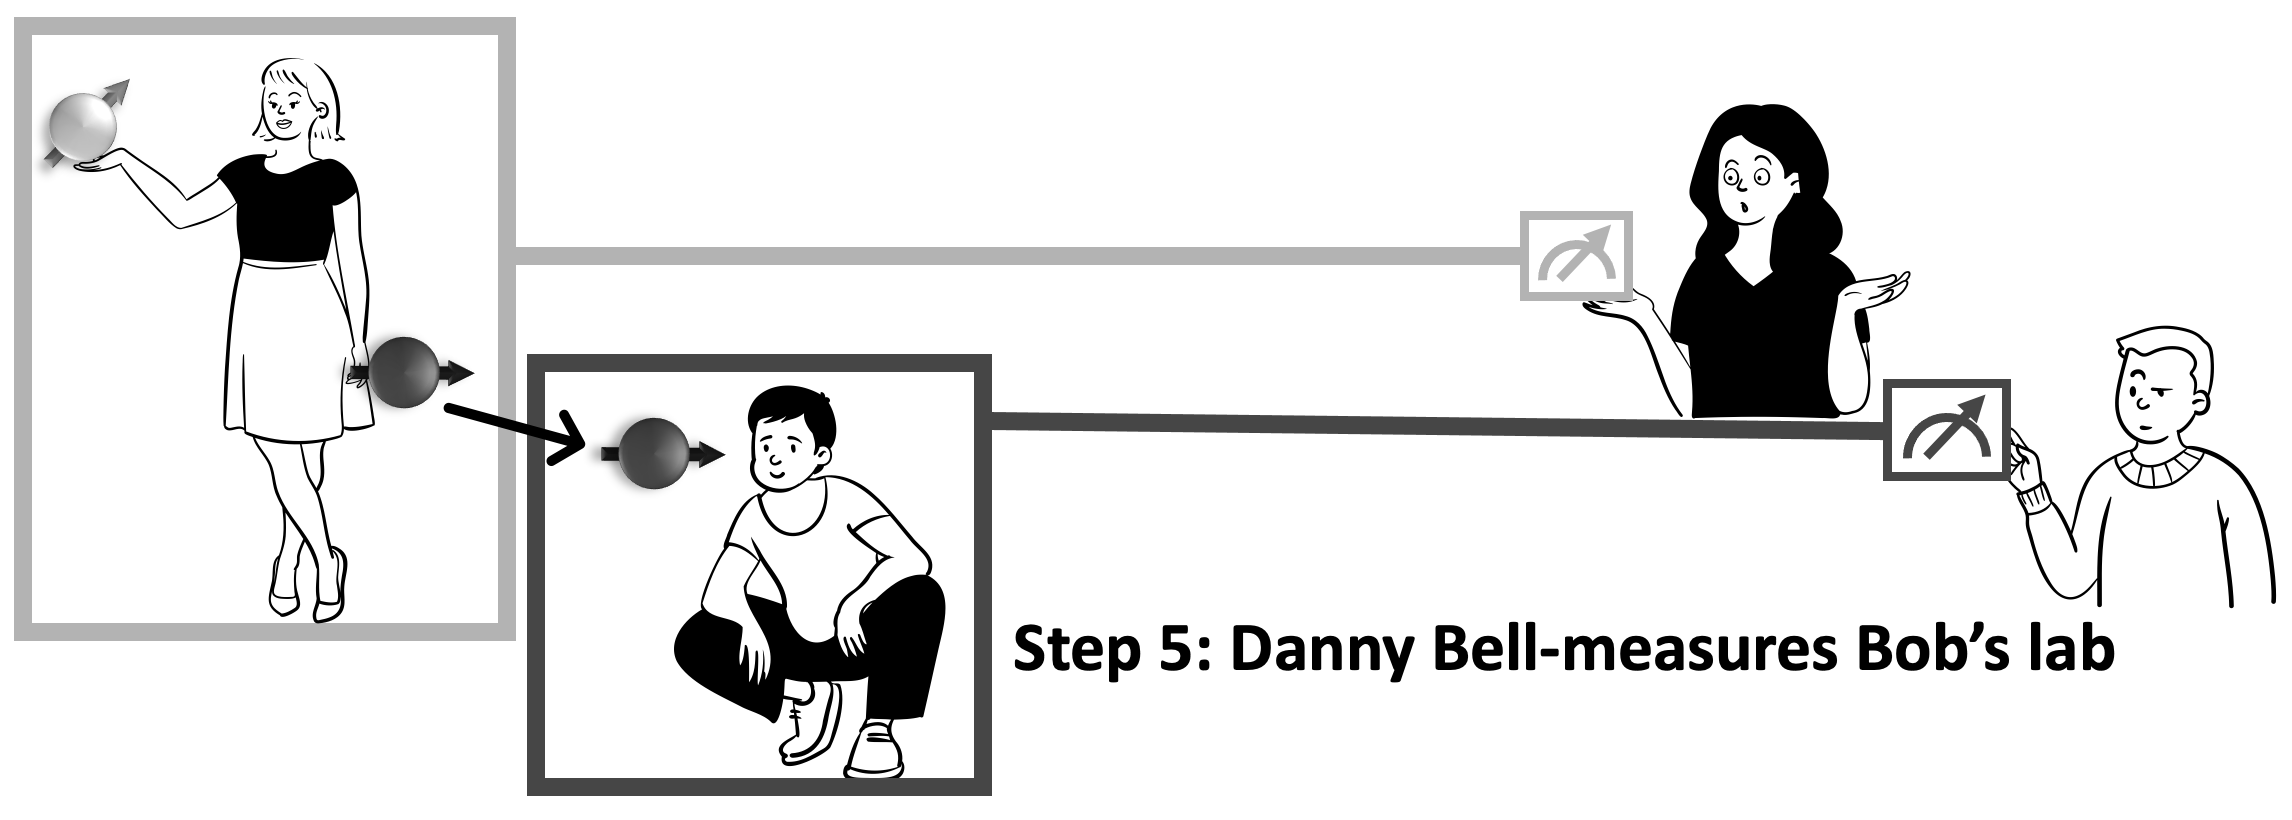

Let's add the measurement to our circuit: 

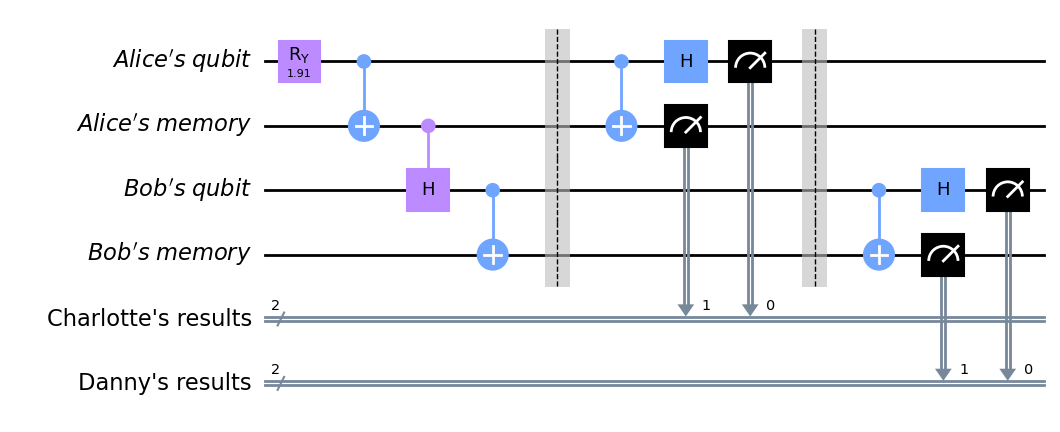

In [8]:
cr2 = ClassicalRegister(2, name="Danny's results")

qc.add_register(cr2)

qc.barrier()

# Bell measurement on the second pair of qubits
qc.cx(2, 3)
qc.h(2)
qc.measure(2, 2)
qc.measure(3, 3)

qc.draw("mpl")

We've concluded that if Charlotte measures 0 1, which corresponds to the Bell state phi-, then Alice measured a 1 on her qubit, so she must have given Bob a qubit in the |+> state. 

Now let's think about what happens if Alice prepares Bob's qubit in the |+> state. When Bob measures a qubit in a |+> state, he will become maximally entangled with the qubit, and together, they will be in the phi+ Bell state, |00> + |11>. 

So when Danny does a Bell measurement, he will definitely find that Bob is in the phi+ state, indicated by outcomes of 00 in the final Z measurements. 

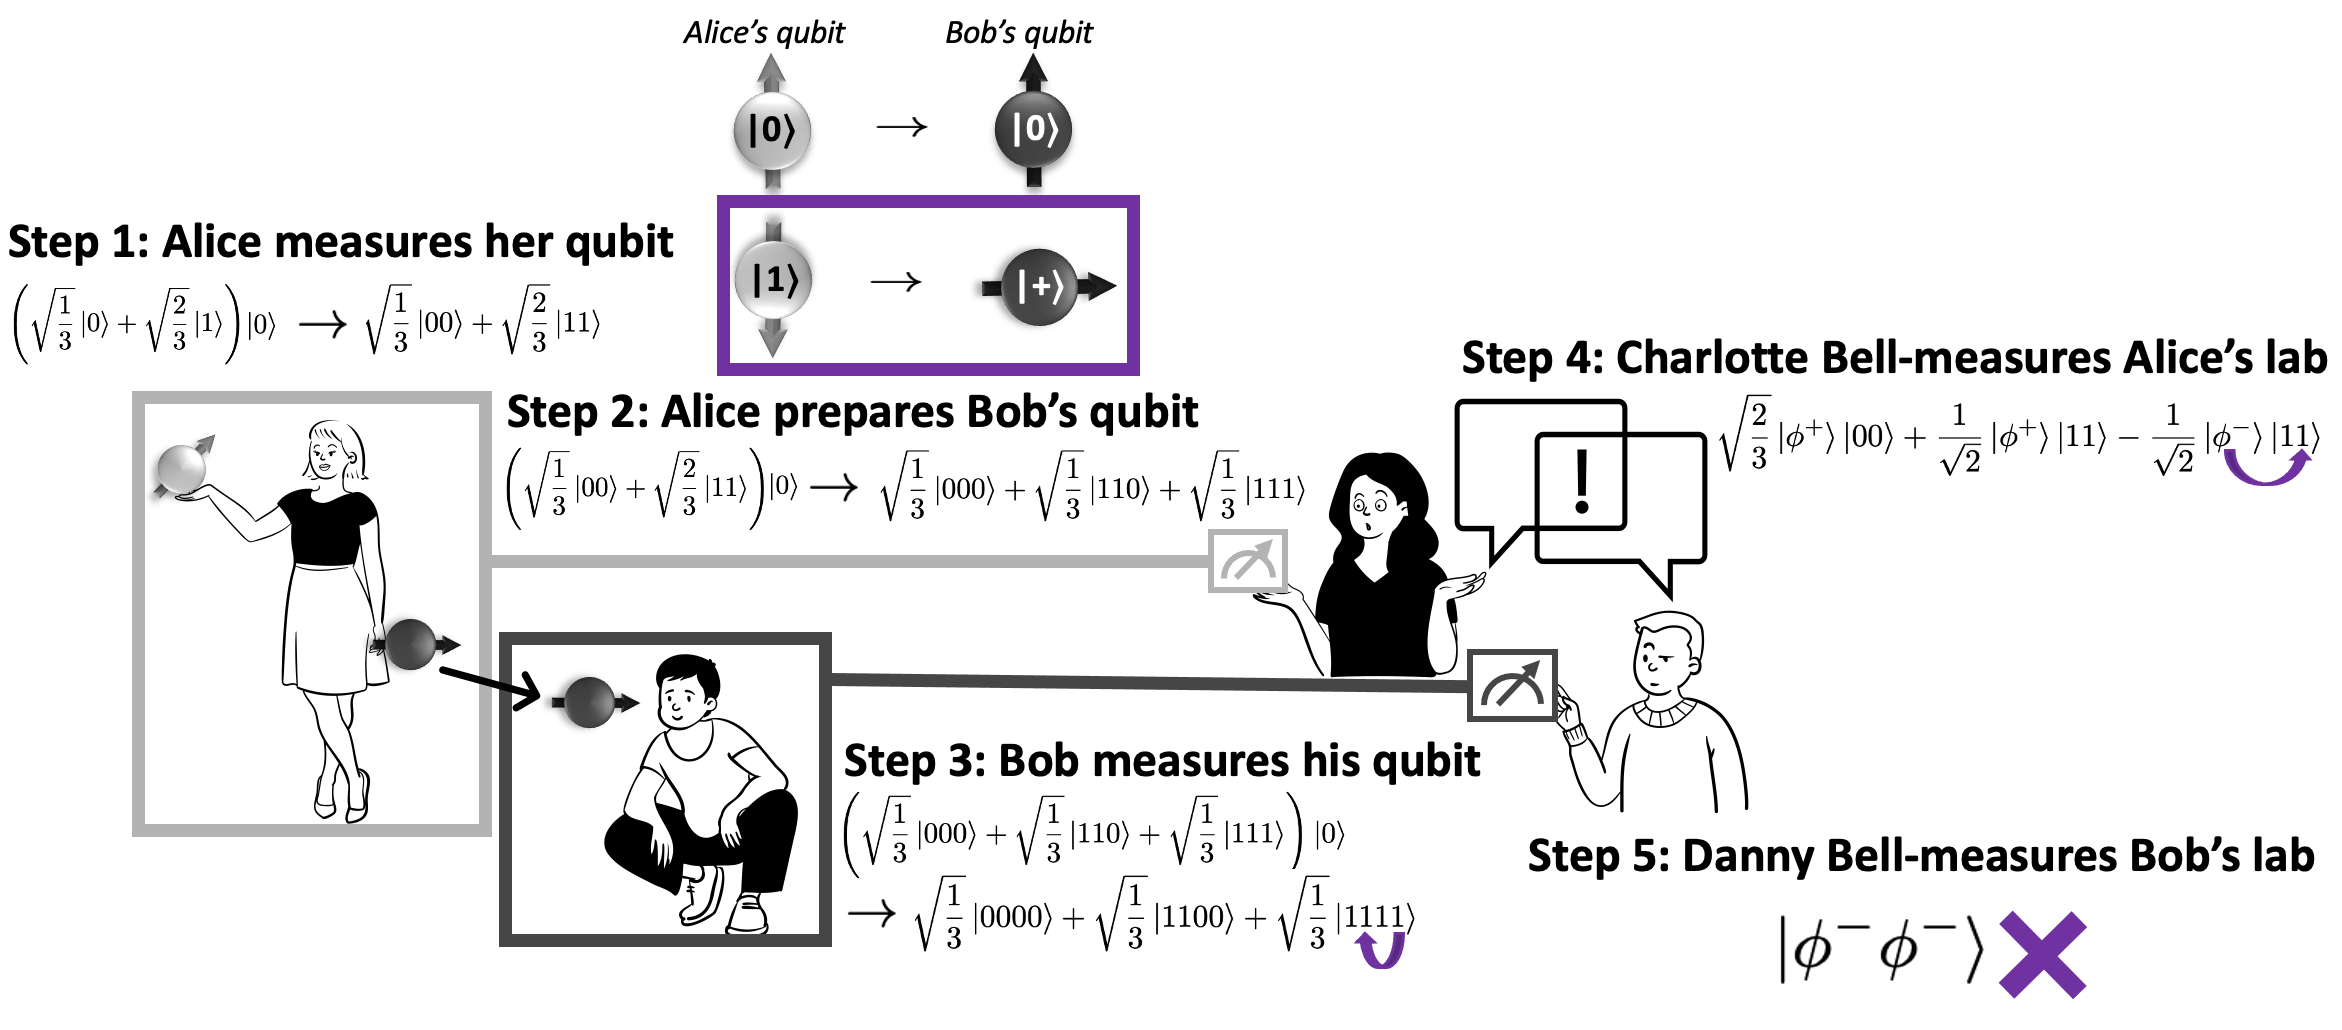

### The paradox 

So our complete chain of reasoning is now: 

If Charlotte measures Alice's lab to be in the state phi-, then Bob definitely measured 1, therefore Alice definitely measured 1, therefore Danny will definitely measure Bob's lab to be in the state phi+. So there should never be any measurements possible such that Charlotte measures phi-, AND Danny measures phi-. In terms of the Z-measurements at the end of our circuit in the computational basis, this means we should never get an outcome where Charlotte measures 01 and Danny measures 01. 

Let's see what actually happens when we run our full circuit with Qiskit: 

In [9]:
transpiled_circuit = transpile(qc, backend)

result = backend.run(transpiled_circuit).result()

counts = result.get_counts(transpiled_circuit)

print("Counts: ", counts)

Counts:  {'00 01': 70, '01 00': 74, '00 00': 800, '01 01': 80}


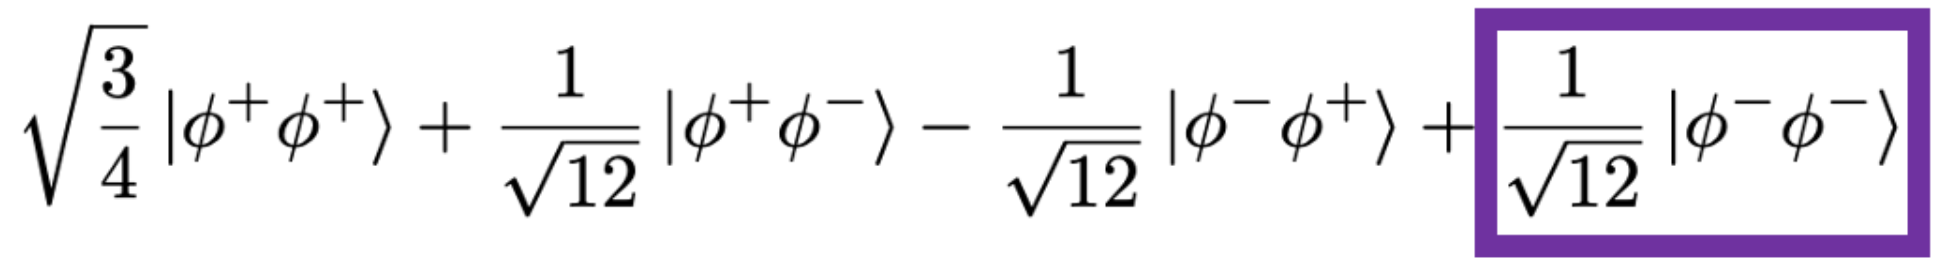

You can see from running the circuit, that we have a paradox! Charlotte and Danny can actually both measure 01. It turns out that they can get this outcome with probability 1/12, as we can see from the global statevector. 

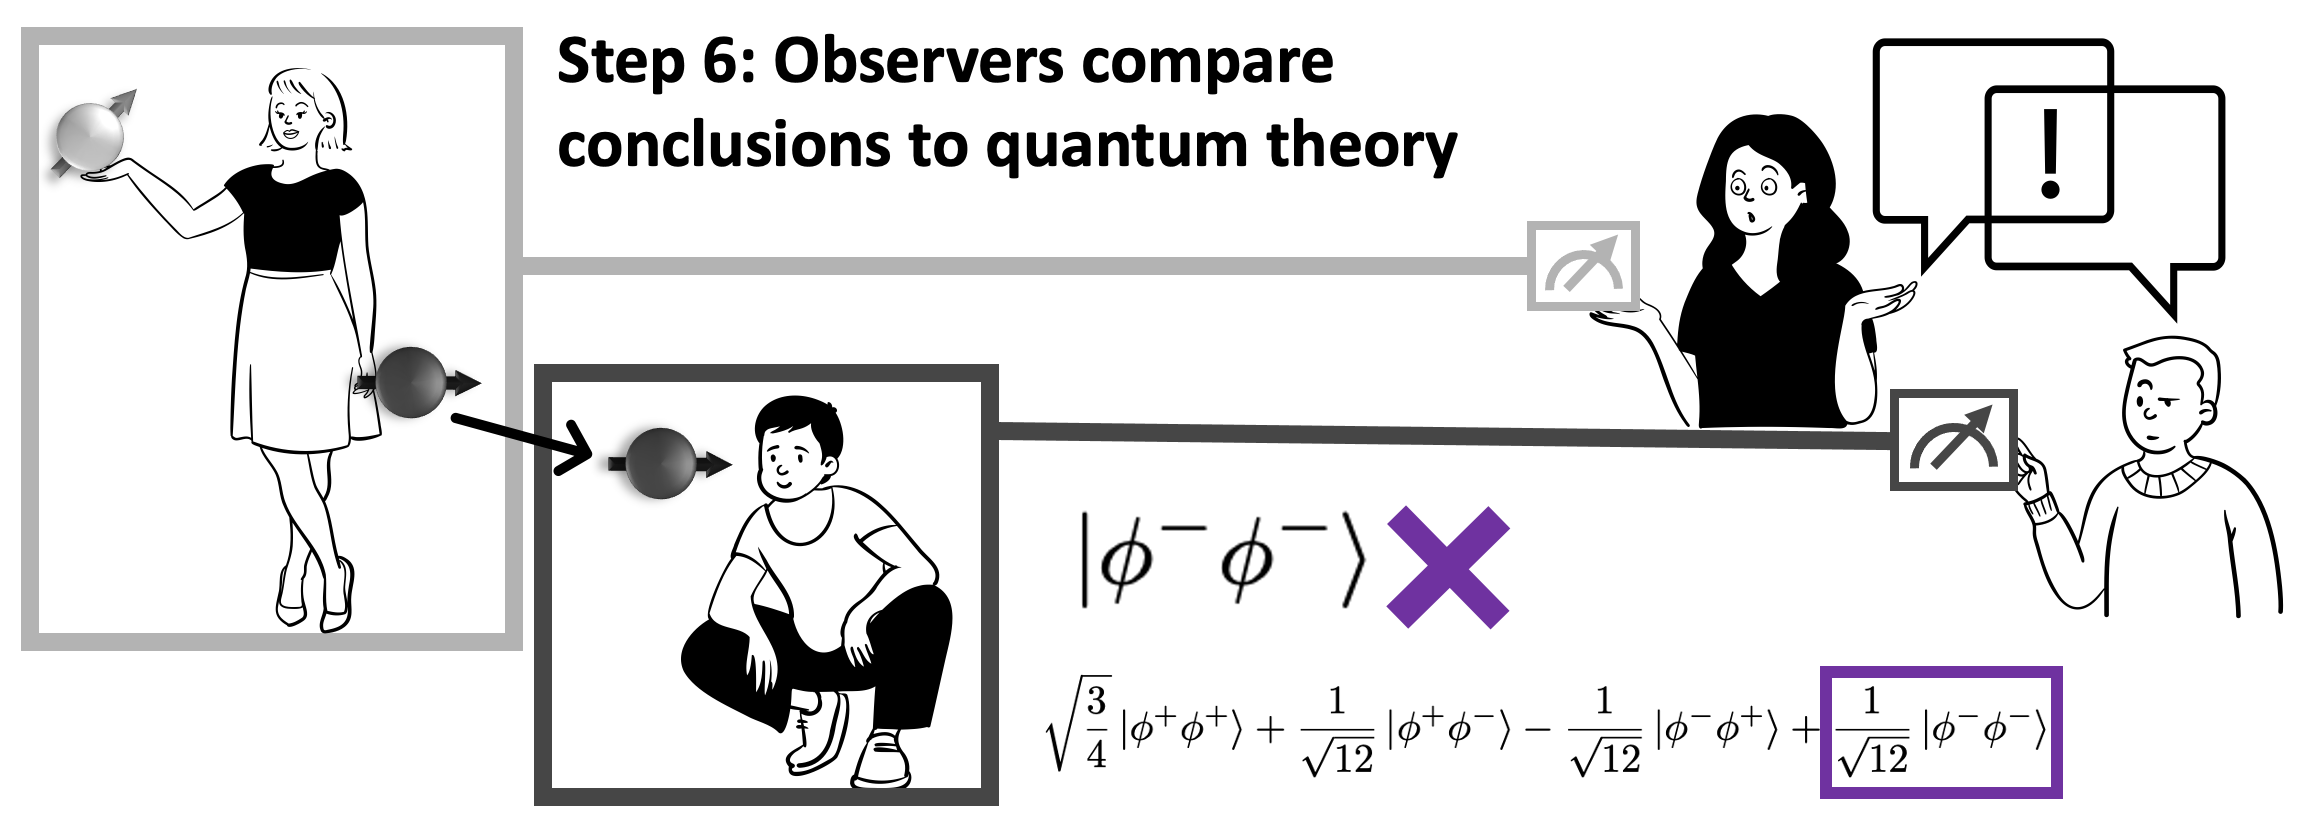

So if the reasoning of the agents is correct, then quantum theory fails to describe observers reasoning about quantum theory. In their original paper, Frauchiger and Renner argued that we have to give up some of our standard assumptions of physics to avoid the paradox. Here I'll explain my way of understanding where the reasoning of the observers that I described earlier goes wrong. 

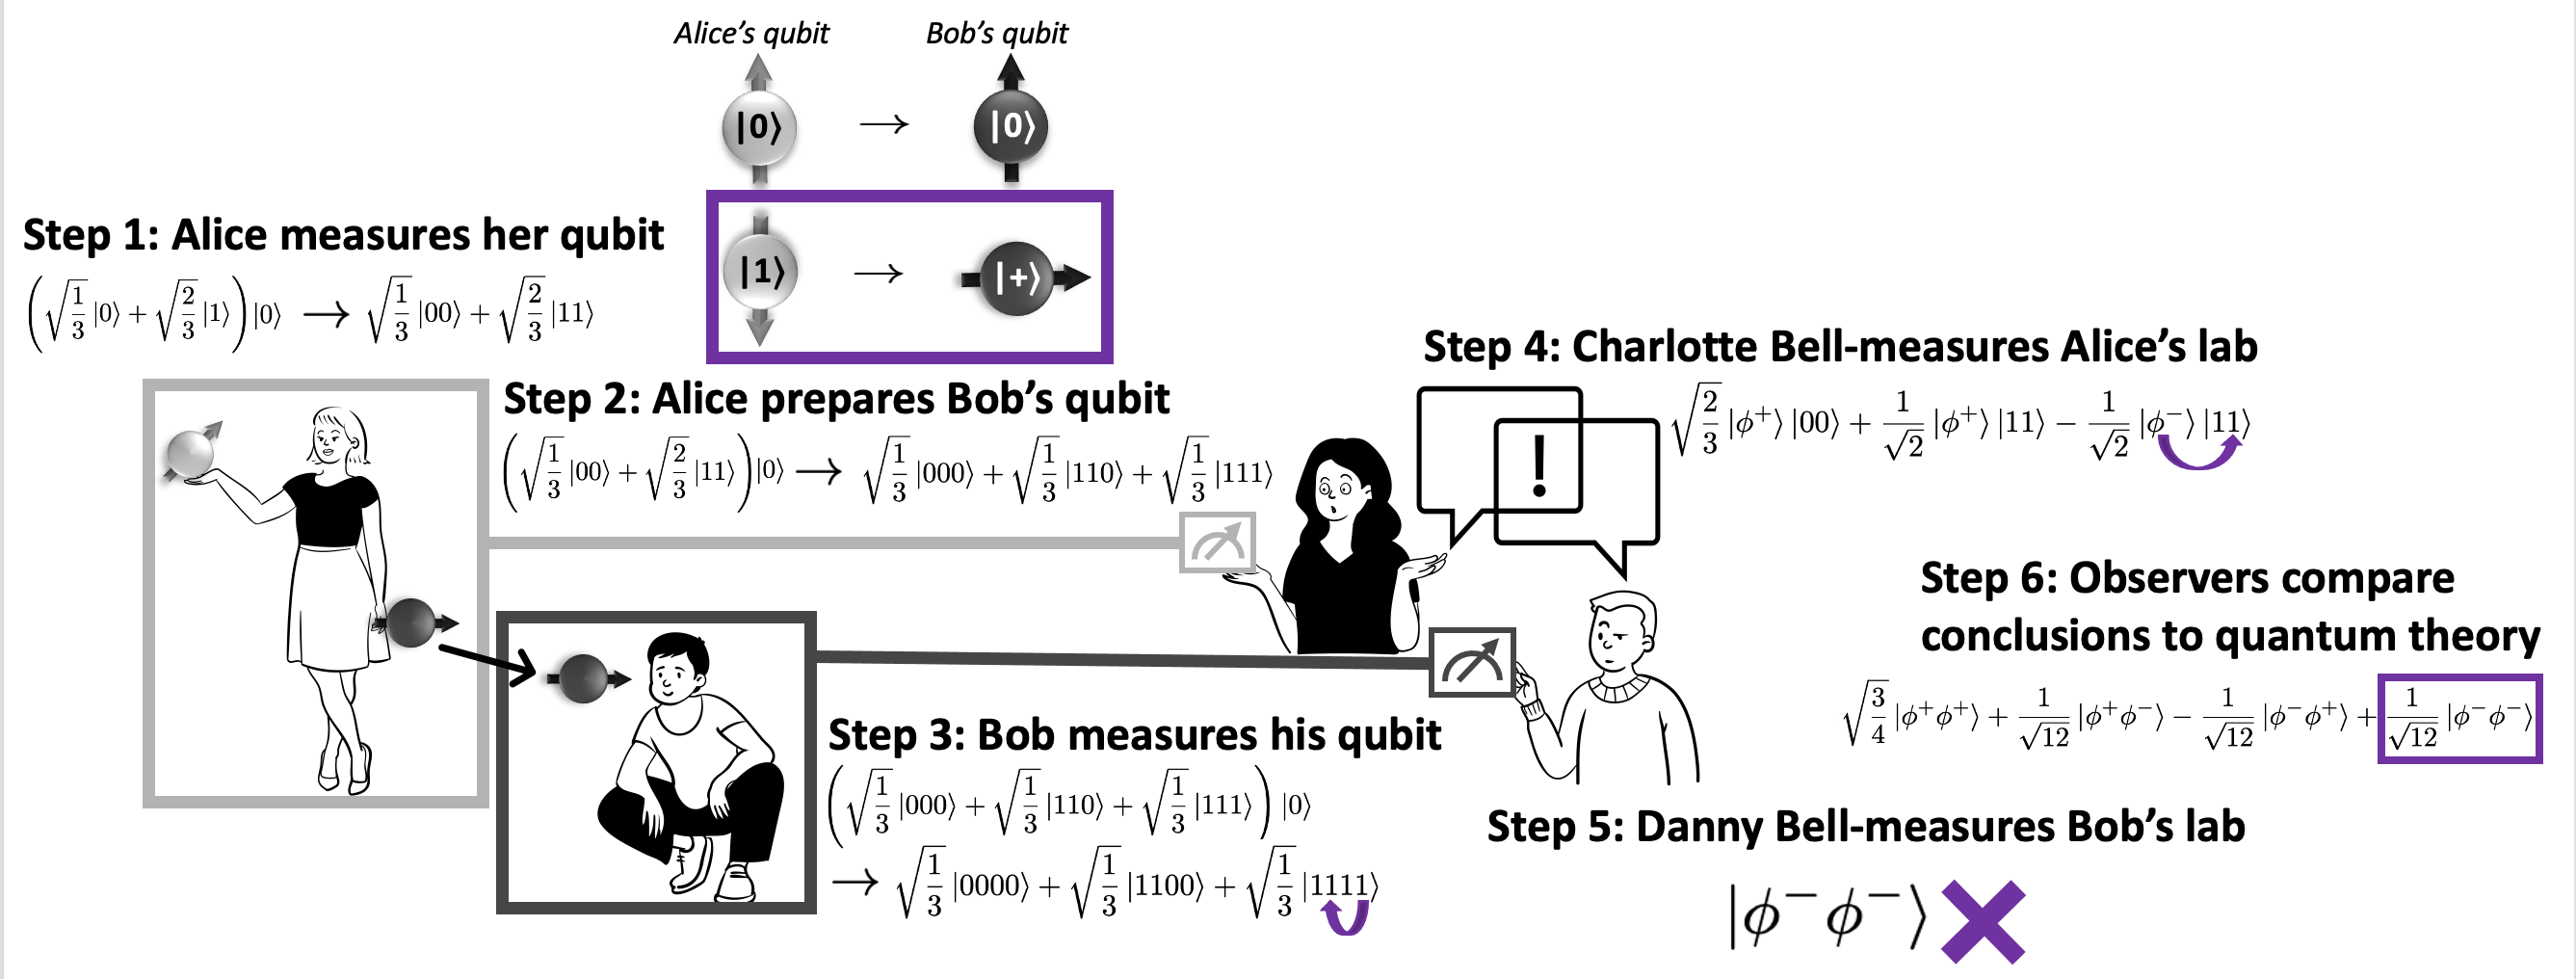

### My resolution: friends in different bases 

I think the key problem is in chaining together Charlotte's conclusion about Bob's past measurement outcome, and Bob's conclusion about Alice's past measurement outcome. 

Let's look at where the measurements Charlotte, Alice and Bob make are on the quantum circuit: 

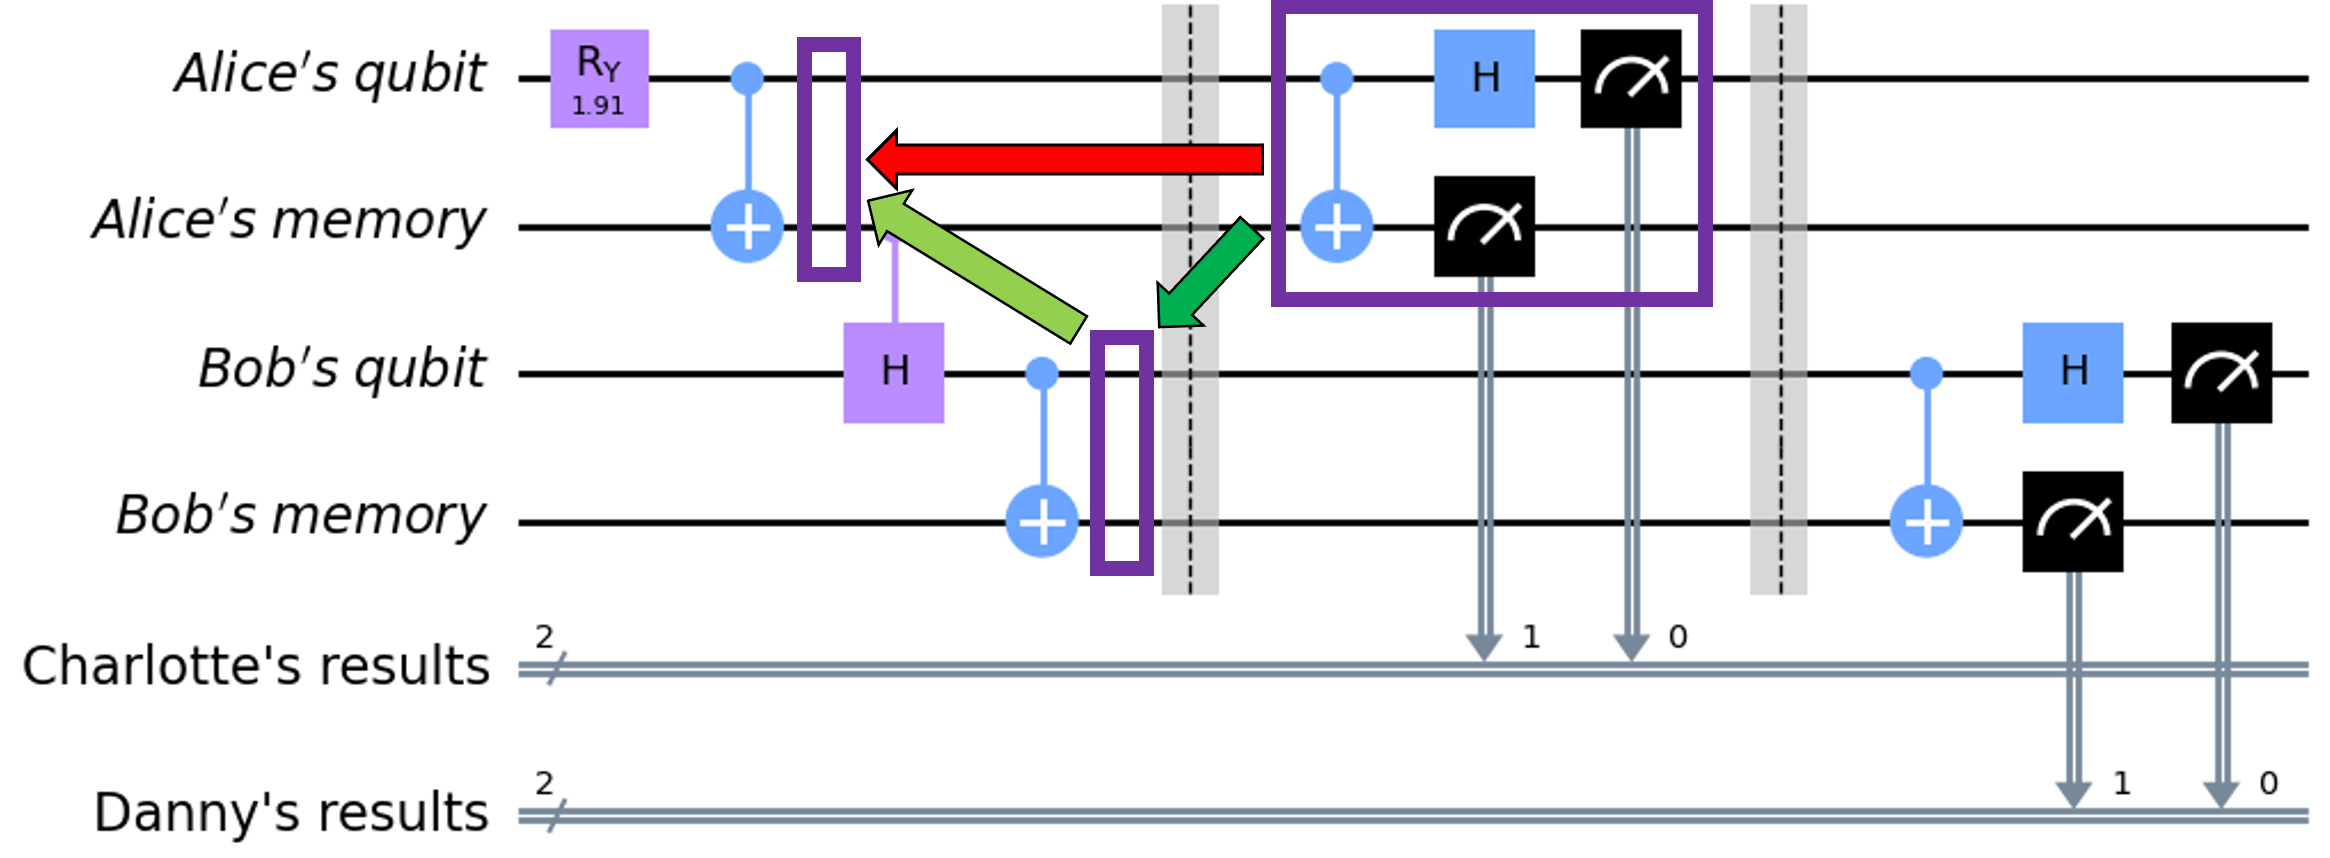

The basis in which Charlotte measures Alice is the Bell basis, whereas the basis in which Alice measured her qubit is the computational basis. In the same way that a quantum system can't have a definite state in the X and Z basis, Alice's lab can't have a definite state in the computational basis and Bell basis. This is another version of Heisenberg's uncertainty principle, where a particle can't have definite position and momentum simultaneously.

In the thought experiment, this means that it's fine for Charlotte to reason about Bob's past measurement outcome, and Bob to reason about Alice's measurement outcome, because each of those individual deductions happen in compatible bases, that refer to different qubits. But Charlotte cannot use Bob's conclusion about Alice's past outcome, because that conclusion involves a measurement basis that is incompatible with Charlotte's measurement basis.

This is very different to classical physics, where we have no problems chaining together deductions from different observers. 

Once we forbid the chaining together of Charlotte and Bob's deductions, there's no reason that Danny is forbidden from measuring phi- if Charlotte measures phi-. Hence there is no contradiction with quantum theory being applied to the reasoning about observations. 

This reasoning is enough to convince me that applying quantum theory to observers is self-consistent - but it remains an open topic of discussion within the quantum community. Different researchers have proposed different resolutions, and some believe that there are still subtleties to be resolved, for example to do with precisely describing the situations where observers can and can't use each others' deductions. 

### Outro 

I've shown you how to implement a qubit version of the thought experiment yourself using Qiskit - but there's an even more fundamental way that quantum computers can be involved in this thought experiment. A possible objection to the paradox is that coherent control over a human observer is technologically unrealistic, even in principle. A work-around is to replace the four human observers with four quantum computers, programmed to reason about their measurement outcomes. This removes the need for conscious agents. Some researchers have even developed a quantum software package enabling you to see what happens in the thought experiment when you use different assumptions on how your observers should reason about their measurement outcomes. 

In this setting, my resolution to the paradox is the same: the quantum computers should be programmed such that they do not chain together deductions that refer to qubits in different bases.

Because of Heisenberg's uncertainty principle, when dealing with any kind of deductions in quantum theory, they can only be applied simultaneously if the relevant measurements are all made in compatible bases. That's how we avoid any variations of the Wigner's friend of a friend of a friend paradox.

In the next video, we're heading right back to the 60s to explain what has been called ["the most beautiful experiment in physics"](https://physicsworld.com/a/the-double-slit-experiment/): the famous double-slit, which was used to demonstrate the weird phenomenon of wave-particle duality. 

See you next time for more quantum thought experiments!

13 min 52 sec